##### Guide For ML Training 

In [1]:
# Importing Required Libs
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

#####  Load Data

In [2]:
# Load
# train = pd.read_csv('path')
# test = pd.read_csv('path')

# Generate Synthetic Data
# Set seed
np.random.seed(42)
# Simulate data
n = 200
data = pd.DataFrame({
    "CustomerID": range(1, n+1),
    "Age": np.random.randint(18, 70, size=n),
    "AnnualIncome": np.random.normal(50, 15, n).round(2),
    "SpendingScore": np.random.randint(1, 101, size=n),
    "Gender": np.random.choice(["Male", "Female"], size=n),
    "Region": np.random.choice(["North", "South", "East", "West"], size=n),
    "MembershipYears": np.random.randint(0, 11, size=n),
    "PreferredChannel": np.random.choice(["Online", "In-store", "Both"], size=n)
})

# Inject missing values
for col in ["Age", "AnnualIncome", "SpendingScore", "MembershipYears"]:
    data.loc[data.sample(frac=0.1).index, col] = np.nan
    
# Define target by binning Spending Score
data['SpendingCategory'] = pd.cut(
    data['SpendingScore'],
    bins=[0, 40, 70, 100],
    labels=['Low', 'Medium', 'High']
)
   
# Preview Data
data.head()

,CustomerID,Age,AnnualIncome,SpendingScore,Gender,Region,MembershipYears,PreferredChannel,SpendingCategory
0,1,NaN,51.91,75.0,Male,South,8.0,Both,High
1,2,NaN,31.26,29.0,Female,North,10.0,Online,Low
2,3,46.0,79.18,36.0,Female,East,7.0,Online,Low
3,4,32.0,47.70,89.0,Female,North,5.0,Both,High
4,5,60.0,NaN,21.0,Female,South,6.0,Online,Low


##### Explore the Data (EDA)

##### Basic Info

In [3]:
# View Shape
data.shape

(200, 9)

In [4]:
# basic info, check for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   CustomerID        200 non-null    int64   
 1   Age               180 non-null    float64 
 2   AnnualIncome      180 non-null    float64 
 3   SpendingScore     180 non-null    float64 
 4   Gender            200 non-null    object  
 5   Region            200 non-null    object  
 6   MembershipYears   180 non-null    float64 
 7   PreferredChannel  200 non-null    object  
 8   SpendingCategory  180 non-null    category
dtypes: category(1), float64(4), int64(1), object(3)
memory usage: 12.9+ KB


In [5]:
# View Mean unique values, etc.
data.describe(include='all')

,CustomerID,Age,AnnualIncome,SpendingScore,Gender,Region,MembershipYears,PreferredChannel,SpendingCategory
count,200.000000,180.000000,180.000000,180.000000,200,200,180.00000,200,180
unique,NaN,NaN,NaN,NaN,2,4,NaN,3,3
top,NaN,NaN,NaN,NaN,Male,South,NaN,In-store,Low
freq,NaN,NaN,NaN,NaN,108,57,NaN,70,82
mean,100.500000,43.111111,50.113667,48.566667,NaN,NaN,5.15000,NaN,NaN
std,57.879185,14.804834,16.034849,28.814781,NaN,NaN,3.19125,NaN,NaN
min,1.000000,18.000000,6.810000,1.000000,NaN,NaN,0.00000,NaN,NaN
25%,50.750000,31.000000,39.402500,23.000000,NaN,NaN,3.00000,NaN,NaN
50%,100.500000,43.500000,49.880000,46.500000,NaN,NaN,5.00000,NaN,NaN
75%,150.250000,56.000000,62.390000,74.000000,NaN,NaN,8.00000,NaN,NaN


##### Missing Value Analysis

In [6]:
# Missing values
data.isna().sum()

CustomerID           0
Age                 20
AnnualIncome        20
SpendingScore       20
Gender               0
Region               0
MembershipYears     20
PreferredChannel     0
SpendingCategory    20
dtype: int64

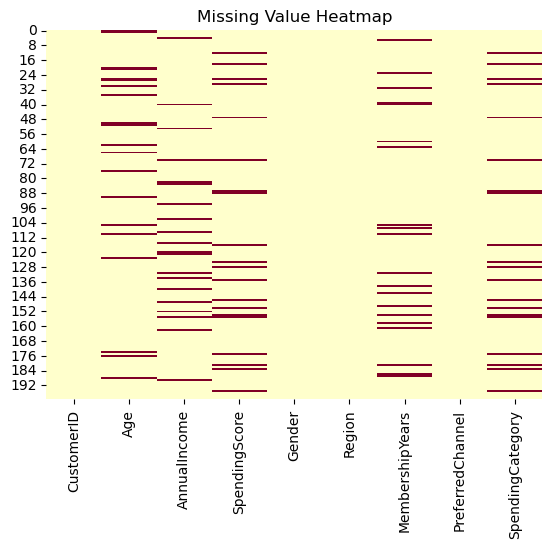

In [7]:
# Visualize where exactly null values lies
sns.heatmap(data.isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Value Heatmap")
plt.show()

##### Univariate Analysis

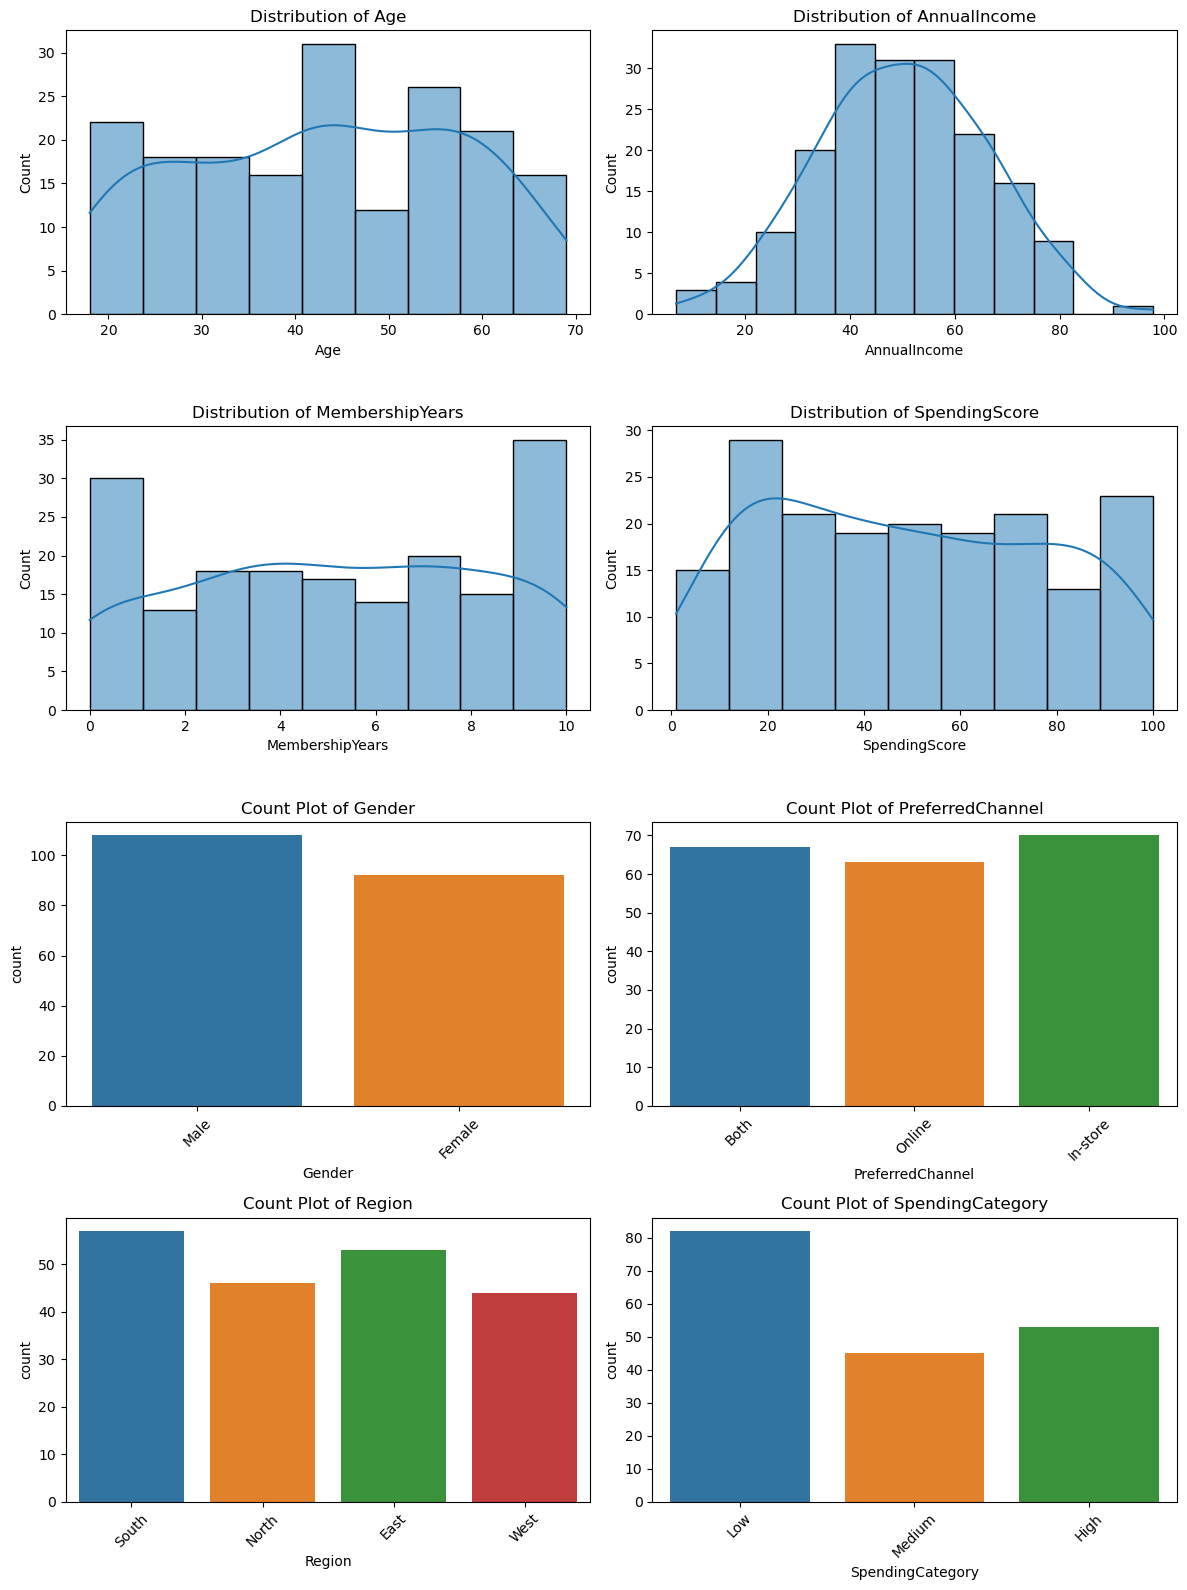

In [8]:
def univariateAnalysis(data, exclude_cols=None):
    """
    Plot histograms for numerical and countplots for categorical features
    in a grid layout.

    Parameters:
        data (pd.DataFrame): The dataset.
        exclude_cols (list): Columns to exclude from plotting (e.g., ID or target cols).
    """
    if exclude_cols is None:
        exclude_cols = []

    # Detect column types
    num_cols = data.select_dtypes(include=[np.number]).columns.difference(exclude_cols).tolist()
    cat_cols = data.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols).tolist()
    all_cols = num_cols + cat_cols

    total_plots = len(all_cols)
    ncols = 2
    nrows = math.ceil(total_plots / ncols)
    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
    axes = axes.flatten()

    for i, col in enumerate(all_cols):
        ax = axes[i]
        if col in num_cols:
            sns.histplot(data[col], kde=True, ax=ax)
            ax.set_title(f"Distribution of {col}")
        elif col in cat_cols:
            sns.countplot(x=col, data=data, ax=ax)
            ax.set_title(f"Count Plot of {col}")
            ax.tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(len(all_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

univariateAnalysis(data, exclude_cols = ['CustomerID'])

##### Bivariate Analysis

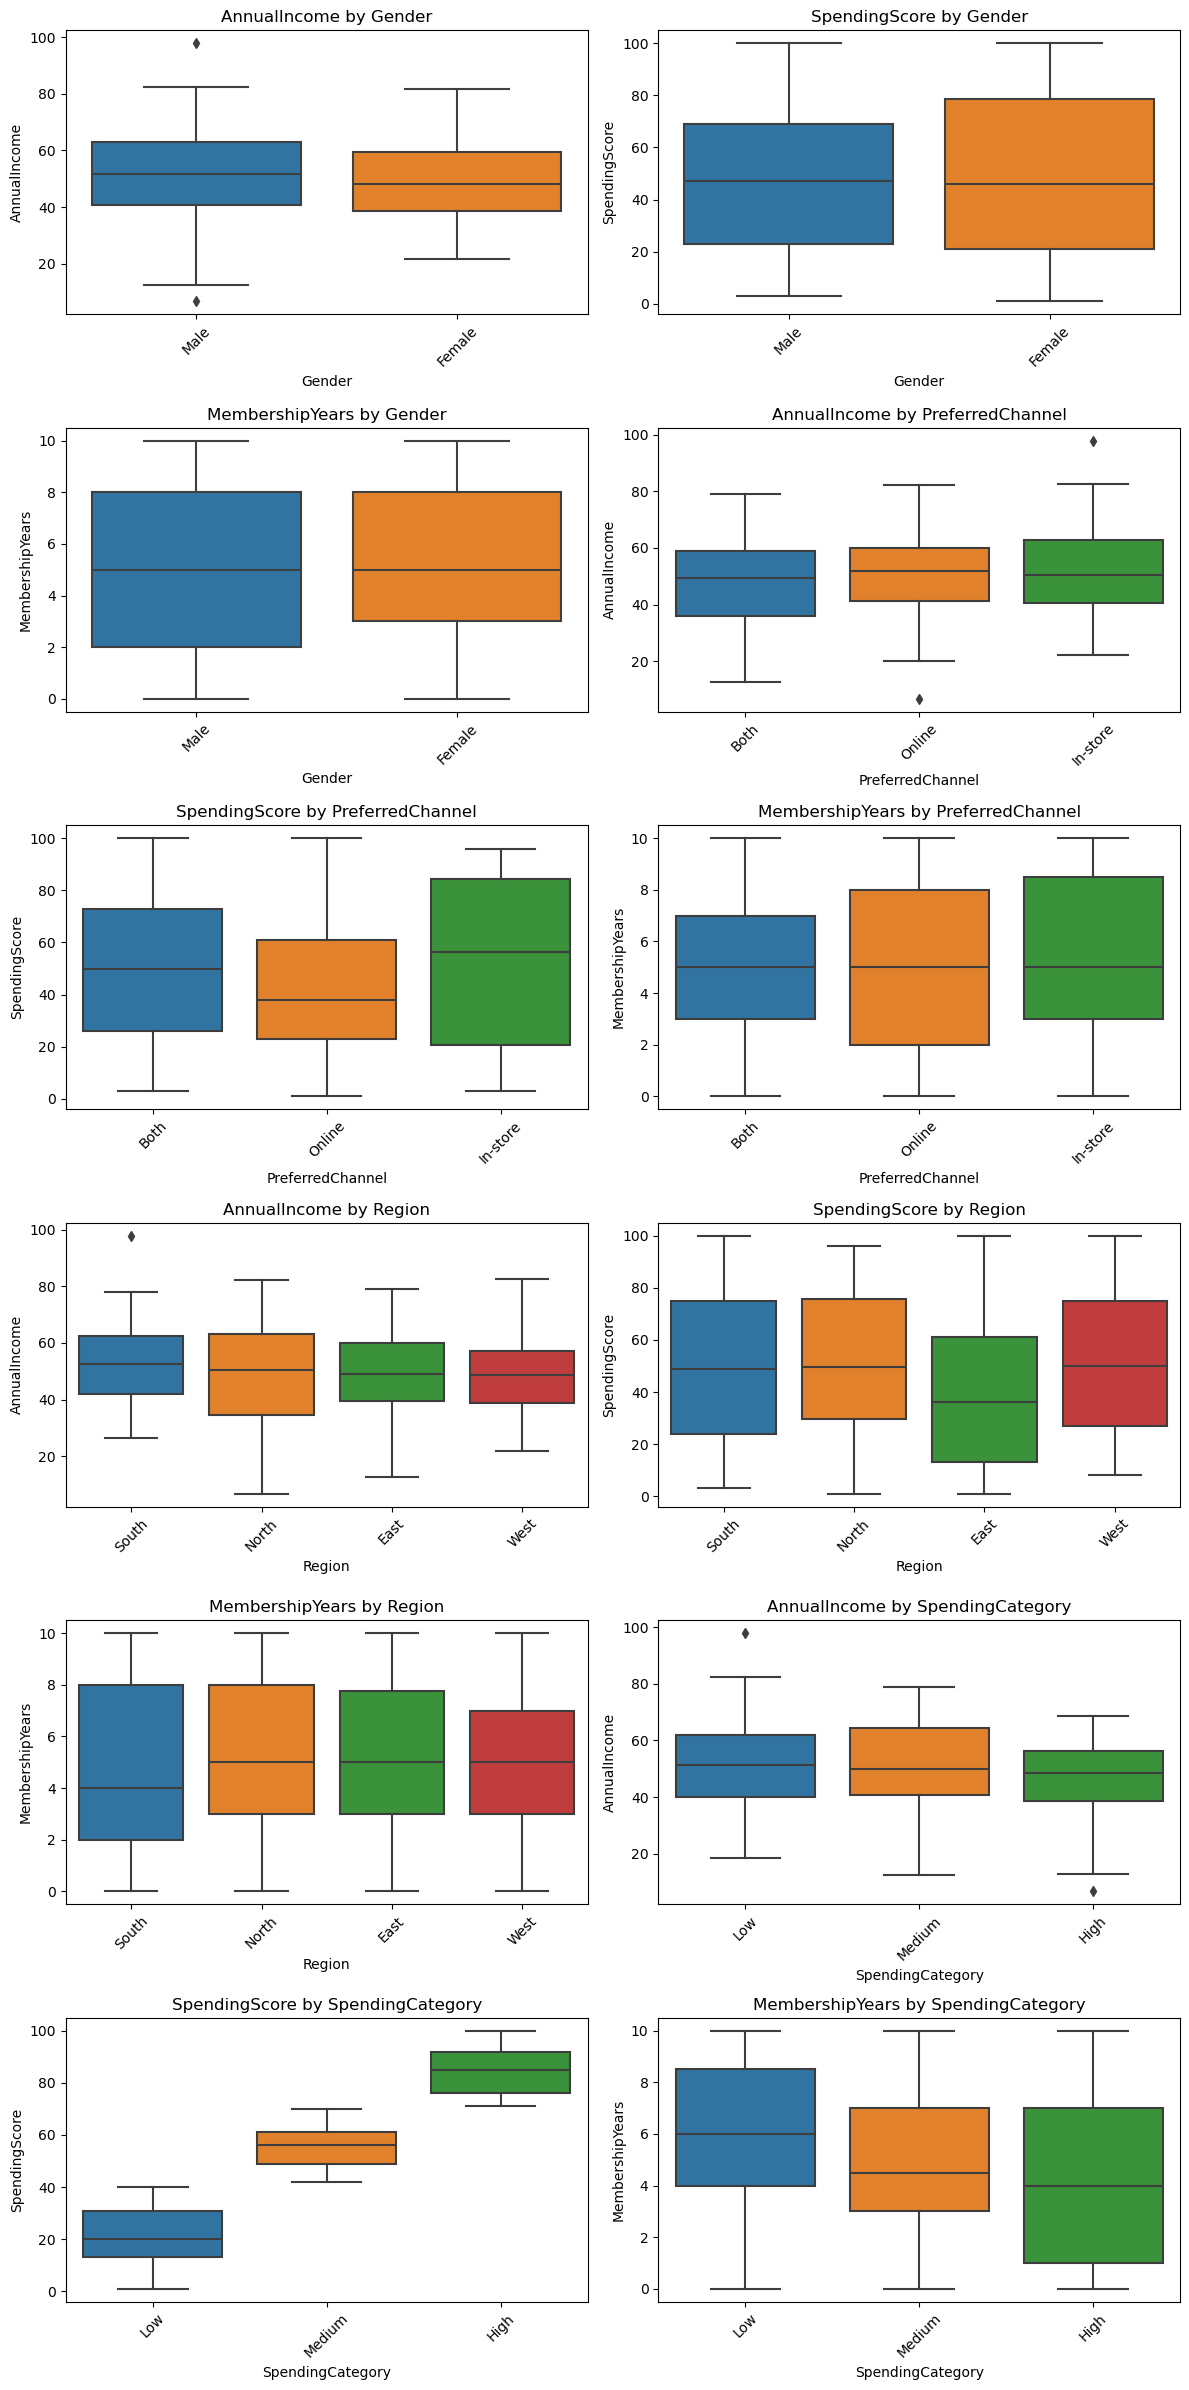

In [9]:
def bivariateAnalysis(data, target_cols, groupby_cols=None, exclude_cols=None):
    """
    Create grid of boxplots for all combinations of groupby_cols vs target_cols.

    Parameters:
        data (pd.DataFrame): The dataset.
        target_cols (list): Numerical columns to plot on y-axis.
        groupby_cols (list): Categorical columns to plot on x-axis. If None, auto-detected.
        exclude_cols (list): Columns to exclude.
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # Detect categorical columns for x-axis if not provided
    if groupby_cols is None:
        groupby_cols = data.select_dtypes(include=['object', 'category']).columns.difference(exclude_cols).tolist()

    # Filter target_cols
    target_cols = [col for col in target_cols if col not in exclude_cols]

    # Prepare combinations (x=groupby_col, y=target_col)
    plot_combinations = [(x, y) for x in groupby_cols for y in target_cols]
    total_plots = len(plot_combinations)

    # Grid dimensions
    ncols = 2
    nrows = math.ceil(total_plots / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 6, nrows * 4))
    axes = axes.flatten()

    for i, (x_col, y_col) in enumerate(plot_combinations):
        sns.boxplot(x=x_col, y=y_col, data=data, ax=axes[i])
        axes[i].set_title(f"{y_col} by {x_col}")
        axes[i].tick_params(axis='x', rotation=45)

    # Hide extra subplots
    for j in range(total_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    
bivariateAnalysis(data=data,target_cols=["AnnualIncome", "SpendingScore", "MembershipYears"],
              exclude_cols=["CustomerID"])

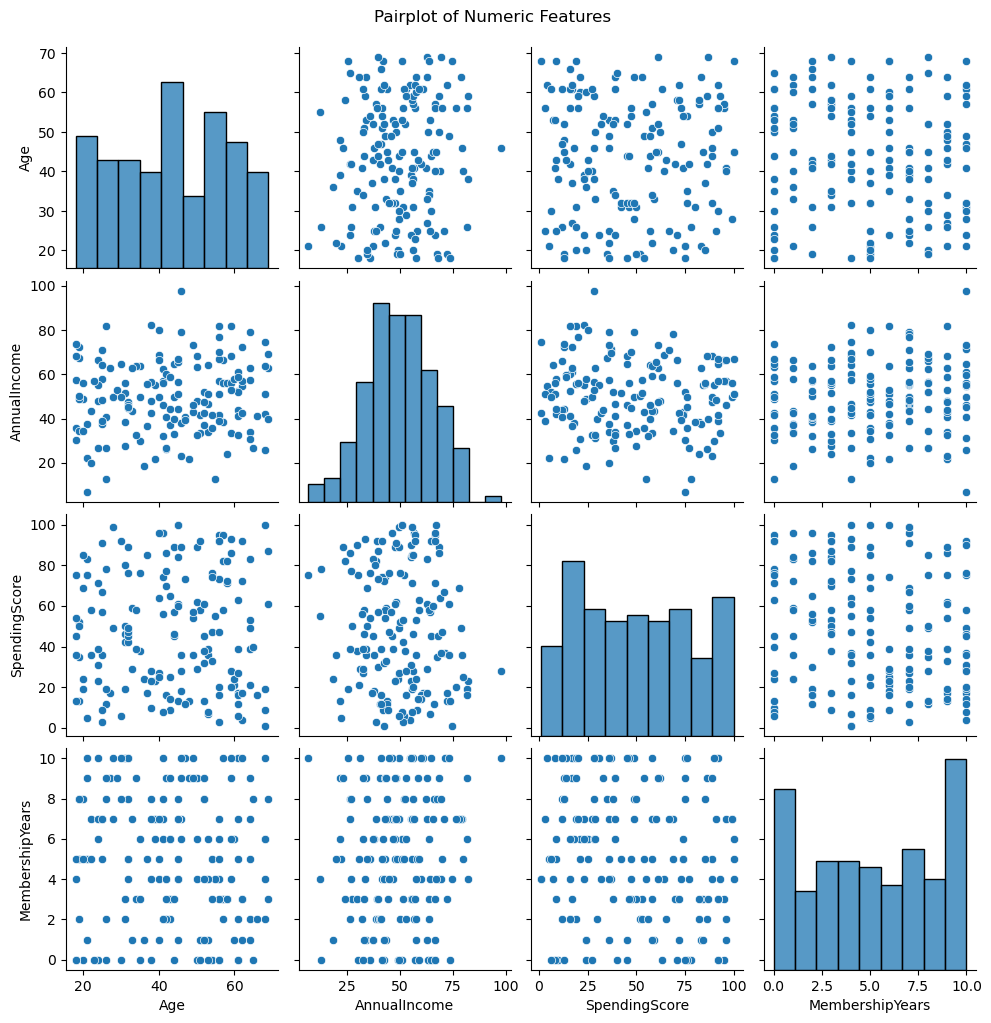

In [10]:
# Now show the pairplot separately (uses its own figure)
num_cols = ["Age", "AnnualIncome", "SpendingScore", "MembershipYears"]
sns.pairplot(data[num_cols])
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

##### Trivariate Analysis

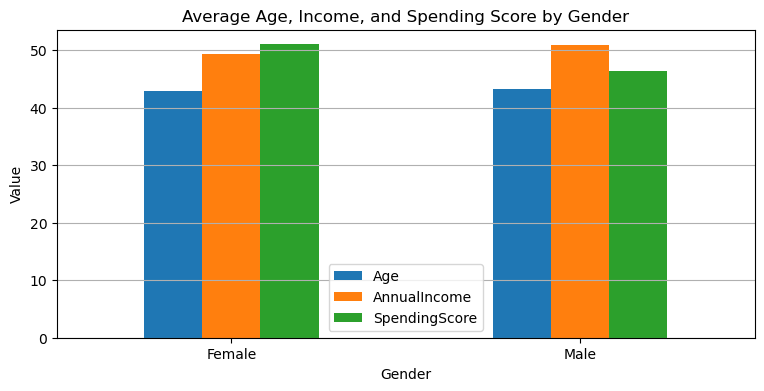

In [11]:
# Group by Gender
gender_group = data.groupby("Gender")[["Age", "AnnualIncome", "SpendingScore"]].mean().round(2)
gender_group.plot(kind="bar", figsize=(9,4))
plt.title("Average Age, Income, and Spending Score by Gender")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

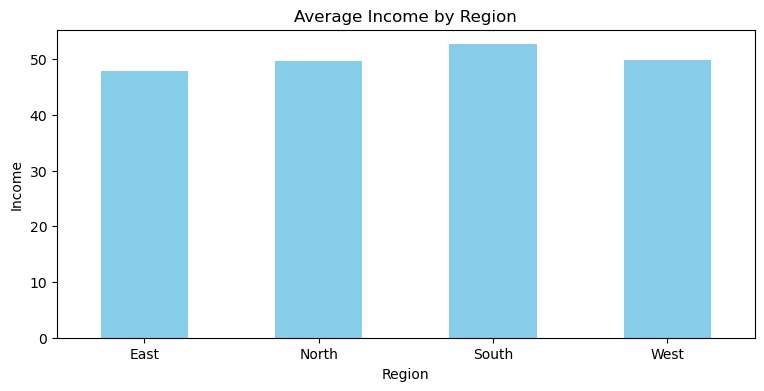

In [12]:
# Group By Region
region_group = data.groupby("Region")[["AnnualIncome", "SpendingScore"]].agg(['mean', 'median', 'count']).round(2)
data.groupby("Region")["AnnualIncome"].mean().plot(kind='bar', color='skyblue', figsize=(9,4))
plt.title("Average Income by Region")
plt.ylabel("Income")
plt.xticks(rotation=0)
plt.show()

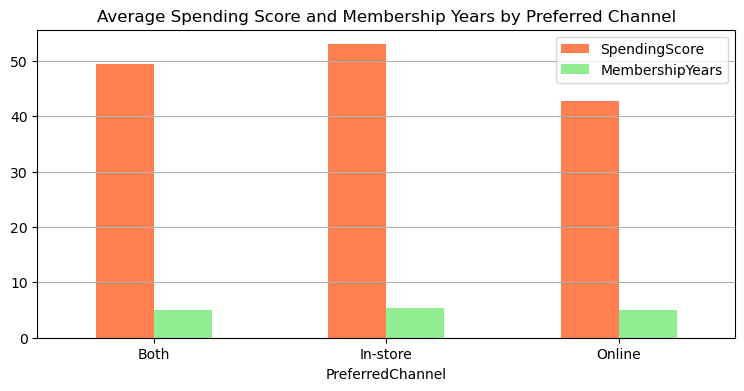

In [13]:
# Group by Channel
channel_group = data.groupby("PreferredChannel")[["SpendingScore", "MembershipYears"]].mean().round(2)
channel_group.plot(kind="bar", figsize=(9,4), color=['coral', 'lightgreen'])
plt.title("Average Spending Score and Membership Years by Preferred Channel")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

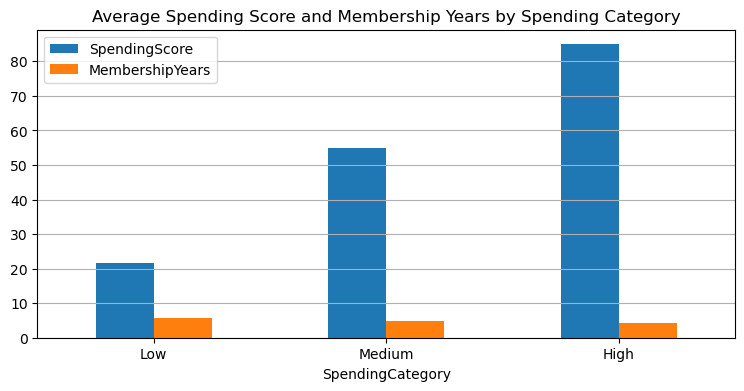

In [14]:
# Group by Spending Category
spendingCategory_group = data.groupby("SpendingCategory")[["SpendingScore", "MembershipYears"]].mean().round(2)
spendingCategory_group.plot(kind="bar", figsize=(9,4))
plt.title("Average Spending Score and Membership Years by Spending Category")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

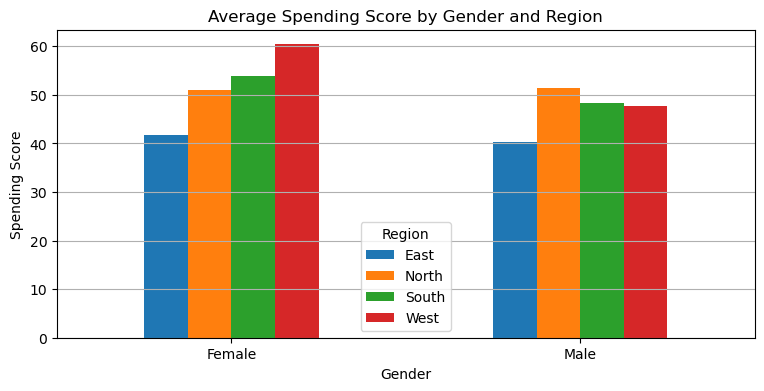

In [15]:
##### Cross Group: Gender & Region
cross_group = data.groupby(["Gender", "Region"])["SpendingScore"].mean().unstack().round(2)
cross_group.plot(kind="bar", figsize=(9,4))
plt.title("Average Spending Score by Gender and Region")
plt.ylabel("Spending Score")
plt.xticks(rotation=0)
plt.legend(title="Region")
plt.grid(axis="y")
plt.show()

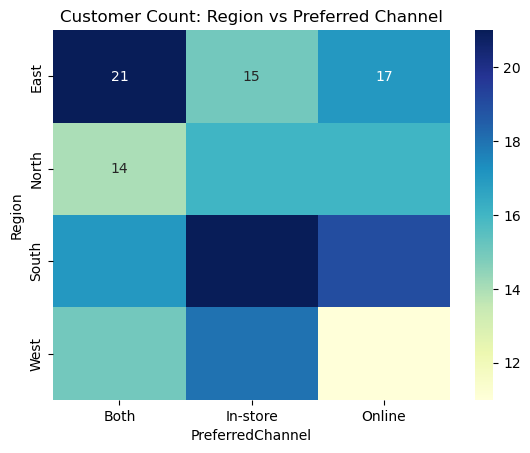

In [16]:
# Count of customers per Region & Channel
region_channel_count = data.groupby(["Region", "PreferredChannel"]).size().unstack()
sns.heatmap(region_channel_count, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Customer Count: Region vs Preferred Channel")
plt.show()

##### Handle Missing Value

In [17]:
def has_outliers(series):
    """Detects if a numeric series has outliers using the IQR method."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((series < lower) | (series > upper)).any()

def impute_missing_values(df):
    """
    Imputes missing values in a DataFrame.
    
    - For numeric columns:
        - Use mean if no outliers
        - Use median if outliers exist
    - For categorical columns:
        - Use mode
    """
    df_imputed = df.copy()
    
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in [np.float64, np.int64]:
                if has_outliers(df[col].dropna()):
                    df_imputed[col].fillna(df[col].median(), inplace=True)
                else:
                    df_imputed[col].fillna(df[col].mean(), inplace=True)
            else:  # Categorical
                mode = df[col].mode()
                if not mode.empty:
                    df_imputed[col].fillna(mode[0], inplace=True)
    
    return df_imputed

# Calling
df = impute_missing_values(data)

In [18]:
# checking df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   CustomerID        200 non-null    int64   
 1   Age               200 non-null    float64 
 2   AnnualIncome      200 non-null    float64 
 3   SpendingScore     200 non-null    float64 
 4   Gender            200 non-null    object  
 5   Region            200 non-null    object  
 6   MembershipYears   200 non-null    float64 
 7   PreferredChannel  200 non-null    object  
 8   SpendingCategory  200 non-null    category
dtypes: category(1), float64(4), int64(1), object(3)
memory usage: 12.9+ KB


##### Handling Outliers

In [19]:
def remove_outliers(df, cols=None):
    """
    Removes rows with outliers in the specified numerical columns using the IQR method.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        cols (list): List of columns to check for outliers. If None, all numerical columns are used.
    
    Returns:
        pd.DataFrame: DataFrame with outliers removed
    """
    df_cleaned = df.copy()
    
    if cols is None:
        cols = df.select_dtypes(include=['float64', 'int64']).columns

    for col in cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

    return df_cleaned

# # Calling 
# df = remove_outliers(df)
# # if you only want to remove outliers from specific columns:
# df = remove_outliers(df, cols=['Age', 'Income'])

##### Label Encoding

In [20]:
def label_encode_categoricals(df):
    """
    Label encodes all categorical (object or category dtype) columns in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
    
    Returns:
        pd.DataFrame: DataFrame with label encoded categorical columns
        dict: Dictionary of fitted LabelEncoders for each column
    """
    df_encoded = df.copy()
    label_encoders = {}
    
    cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns
    
    for col in cat_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
    
    return df_encoded, label_encoders


df_encoded, encoders = label_encode_categoricals(df)

# Preview
df_encoded.head(3)

,CustomerID,Age,AnnualIncome,SpendingScore,Gender,Region,MembershipYears,PreferredChannel,SpendingCategory
0,1,43.111111,51.91,75.0,1,2,8.0,0,0
1,2,43.111111,31.26,29.0,0,1,10.0,2,1
2,3,46.000000,79.18,36.0,0,0,7.0,2,1


##### Feature Scaling

In [21]:
def standardize_numerical(df):
    """
    Standardizes all numerical columns in the DataFrame (zero mean, unit variance).

    Parameters:
        df (pd.DataFrame): Input DataFrame

    Returns:
        pd.DataFrame: DataFrame with standardized numerical columns
        StandardScaler: Fitted scaler object (for transforming test data)
    """
    df_standardized = df.copy()
    scaler = StandardScaler()

    # Select numerical columns only
    num_cols = df_standardized.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Reshape properly to avoid 1D array error
    df_standardized[num_cols] = scaler.fit_transform(df_standardized[num_cols].values.reshape(-1, len(num_cols)))

    return df_standardized, scaler


df_standardized, scalers = standardize_numerical(df_encoded)

# Preview
df_standardized.head()

,CustomerID,Age,AnnualIncome,SpendingScore,Gender,Region,MembershipYears,PreferredChannel,SpendingCategory
0,-1.723412,0.000000,0.119955,0.969673,1,2,0.944001,0,0
1,-1.706091,0.000000,-1.241298,-0.717778,0,1,1.606458,2,1
2,-1.688771,0.206260,1.917601,-0.460992,0,0,0.612773,2,1
3,-1.671450,-0.793309,-0.157569,1.483244,0,1,-0.049684,0,0
4,-1.654129,1.205830,-0.013863,-1.011247,0,2,0.281544,2,1


##### Model Training

In [22]:
# Train-Test Split
X = df_standardized.drop(columns=["SpendingCategory"])
y = df_standardized["SpendingCategory"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [23]:
# Model Training
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_scores = accuracy_score(y_test, y_pred)

print(accuracy_scores)
# # Saving Model Pickle
# with open("give_path",'wb') as f:
#     pickle.dump(model,f)

1.0


In [24]:
# Validation Stats
predictions = {}
cM = confusion_matrix(y_test, y_pred)
total = X_test.shape[0]

predictions["trainingAccuracy"] = accuracy_scores
predictions["truePositive"] = {"value": cM[0][0], "percentage": round(cM[0][0] / total * 100, 2)}
predictions["trueNegative"] = {"value": cM[1][1], "percentage": round(cM[1][1] / total * 100, 2)}
predictions["falsePositive"] = {"value": cM[1][0], "percentage": round(cM[1][0] / total * 100, 2)}
predictions["falseNegative"] = {"value": cM[0][1], "percentage": round(cM[0][1] / total * 100, 2)}

print(predictions)

{'trainingAccuracy': 1.0, 'truePositive': {'value': 7, 'percentage': 17.5}, 'trueNegative': {'value': 23, 'percentage': 57.5}, 'falsePositive': {'value': 0, 'percentage': 0.0}, 'falseNegative': {'value': 0, 'percentage': 0.0}}
